In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import pandas as pd
from PyFunctions import Functions as func
from PyFunctions import var
from PyFunctions import Viz
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using plaidml.keras.backend backend.


### Mobilenet

In [5]:
def get_mobilenet(dim):
    model = Sequential()
    optimizer = Adam(lr = .0005)
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_tensor=Input(shape=dim))
    
    model.add(baseModel)
    headModel = model.add(AveragePooling2D(pool_size=(7, 7)))
    headModel = model.add(Flatten(name="flatten"))
    headModel = model.add(Dense(256, activation="relu"))
    headModel = model.add(Dropout(0.3))
    headModel = model.add(Dense(3, activation="softmax", name = 'Output'))

    for layer in baseModel.layers:
        layer.trainable = False
    
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [3]:
x_train, x_test, y_train, y_test = func.get_tts('mobilenet', version =2, edge = False, balance = True)

Train Value Counts
1    1368
0    1368
2    1233
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
1    152
0    152
2    137
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(3969, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(441, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [6]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=30, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/Mobilenet.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 16

dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
    
mobile_net = get_mobilenet(dim =dim)

    
mobilenet_history = mobile_net.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Train on 3969 samples, validate on 441 samples
Epoch 1/2000
3969/3969 [==============================] - 75s 19ms/step - loss: 0.5884 - acc: 0.7503 - val_loss: 0.8567 - val_acc: 0.6531

Epoch 00001: val_loss improved from inf to 0.85672, saving model to ModelWeights/Mobilenet.h5
Epoch 2/2000
3969/3969 [==============================] - 26s 6ms/step - loss: 0.4936 - acc: 0.7994 - val_loss: 1.0359 - val_acc: 0.6145

Epoch 00002: val_loss did not improve from 0.85672
Epoch 3/2000
3969/3969 [==============================] - 26s 6ms/step - loss: 0.4457 - acc: 0.8188 - val_loss: 0.5701 - val_acc: 0.7846

Epoch 00003: val_loss improved from 0.85672 to 0.57008, saving model to ModelWeights/Mobilenet.h5
Epoch 4/2000
3969/3969 [==============================] - 26s 6ms/step - loss: 0.4156 - acc: 0.8282 - val_loss: 0.7766 - val_acc: 0.7392

Epoch 00004: val_loss did not improve from 0.57008
Epoch 5/2000
3969/3969 [==============================] - 26s 6ms/step - loss: 0.4065 - acc: 0.8304 - val_

3969/3969 [==============================] - 26s 7ms/step - loss: 0.1262 - acc: 0.9559 - val_loss: 0.3408 - val_acc: 0.8798

Epoch 00040: val_loss did not improve from 0.33802
Epoch 41/2000
3969/3969 [==============================] - 26s 7ms/step - loss: 0.1219 - acc: 0.9599 - val_loss: 0.3451 - val_acc: 0.8798

Epoch 00041: val_loss did not improve from 0.33802
Epoch 42/2000
3969/3969 [==============================] - 26s 7ms/step - loss: 0.1151 - acc: 0.9620 - val_loss: 0.3548 - val_acc: 0.8821

Epoch 00042: val_loss did not improve from 0.33802
Epoch 43/2000
3969/3969 [==============================] - 26s 7ms/step - loss: 0.1205 - acc: 0.9569 - val_loss: 0.3512 - val_acc: 0.8844

Epoch 00043: val_loss did not improve from 0.33802
Epoch 44/2000
3969/3969 [==============================] - 26s 7ms/step - loss: 0.1088 - acc: 0.9620 - val_loss: 0.3505 - val_acc: 0.8866

Epoch 00044: val_loss did not improve from 0.33802
Epoch 45/2000
3969/3969 [==============================] - 26s 7

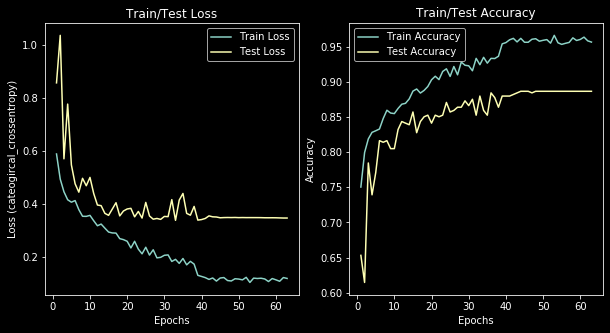

In [7]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background', path = 'figures/MobileLossAcc.png')  

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9205298013245033
HandGun: 0.8516129032258065
Rifle: 0.8666666666666667


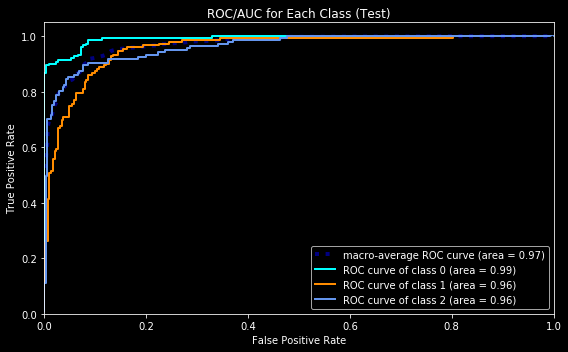

In [9]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/Mobilenet.h5') #load the best weights before overfitting

Viz.plot_roc_auc(mobilenet, x_test, y_test, 'dark_background', 'figures/MobileROC.png')

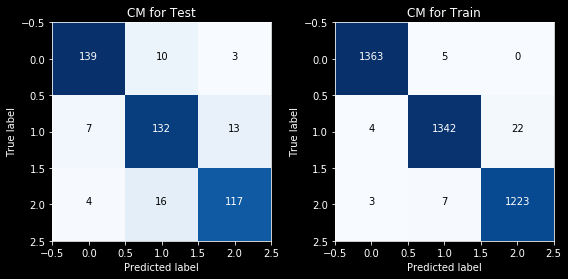

In [11]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/Mobilenet.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in mobilenet.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/MobileCM.png')